In [56]:
# Libraries (will need to export to requirements.txt)

import wptools
from bs4 import BeautifulSoup
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import collections
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/evanpkchapple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/evanpkchapple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [57]:
# Pull 100 biographies from wikipedia for each category

In [3]:
category1 = 'actors' # Give the category of entities for the first category
category2 = 'list of inventors' # Give the category of entities for the second category

In [4]:
def is_person(name):
    """
    :param str name: name of an object
    :return bool: whether the object is a person
    """
    
    sparql = SPARQLWrapper("https://dbpedia.org/sparql")
    
    modified_name = name.replace(' ', '_').replace("'", '%27')
    
    query = """
            ASK {
                dbr:%s a dbo:Person .
            }
            """ % modified_name
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    try:
        result = sparql.query().convert()
        return result['boolean']
    except:
        return False

In [5]:
def populate_people(category, limit=50):
    """
    :param str category: category to search for people in
    :return list: contains the links to wikipedia pages
    """
    people = []
    page = wptools.page(category)
    query = page.get_query()
    for w in query.data['links']:
        if is_person(w):
            people.append(w)
            if len(people) > limit - 1:
                break
    return people

In [6]:
people1 = populate_people(category1, limit=5)
people2 = populate_people(category2, limit=5)

en.wikipedia.org (query) actors
en.wikipedia.org (imageinfo) File:William Hogarth - David Garrick...
Actor (en) data
{
  WARNINGS: <dict(1)> extracts
  aliases: <list(5)> actors, actresses, actress, movie actresses, ...
  assessments: <dict(5)> Television, Film, Theatre, Radio, Occupations
  description: <str(98)> person who acts in a dramatic or comic pr...
  extext: <str(1509)> An **actor** or **actress** is a person who ...
  extract: <str(1753)> <link rel="mw-deduplicated-inline-style" hr...
  image: <list(2)> {'kind': 'query-pageimage', 'file': 'File:Willi...
  label: actor
  length: 44,769
  links: <list(346)> 4th century, 5th centuries, A Funny Thing Hap...
  modified: <dict(1)> page
  pageid: 21504235
  random: RAF Glatton
  redirected: <list(1)> {'from': 'Actors', 'to': 'Actor'}
  redirects: <list(23)> {'pageid': 648, 'ns': 0, 'title': 'Actress...
  requests: <list(2)> query, imageinfo
  title: Actor
  url: https://en.wikipedia.org/wiki/Actor
  url_raw: https://en.wikipedia.or

In [7]:
print(people1)
print(people2)

['Acting instructor', 'Actor-manager', 'Adam de la Halle', 'Albert Capellani', 'Animator']
['A. Baldwin Wood', 'Abd al-Rahman al-Sufi', 'Abram Alikhanov', 'Abu-Mahmud Khojandi', 'Abū Ishāq Ibrāhīm al-Zarqālī']


In [102]:
def get_text(page):
    try:
        page = wptools.page(page)
        query = page.get()
        return query.data['wikitext'].replace('.<', '. <')
    except:
        return ""

In [103]:
df = pd.DataFrame({'people' : people1+people2})

In [104]:
df['category'] = pd.Series([category1]*len(people1) + [category2]*len(people2))

In [105]:
df['text'] = df['people'].apply(get_text)

en.wikipedia.org (query) Acting instructor
en.wikipedia.org (parse) 15098680
www.wikidata.org (wikidata) Q4676869
www.wikidata.org (labels) P646|Q28135085|Q28640|P1368|Q2449921|Q1...
en.wikipedia.org (restbase) /page/summary/Acting_instructor
Acting instructor (en) data
{
  WARNINGS: <dict(1)> extracts
  aliases: <list(3)> acting teacher, acting professor, acting coach
  assessments: <dict(2)> Theatre, Occupations
  claims: <dict(10)> P31, P2521, P646, P460, P279, P244, P2163, P1...
  exhtml: <str(305)> <p>An <b>Acting Instructor</b> is a person, u...
  exrest: <str(291)> An Acting Instructor is a person, usually wel...
  extext: <str(291)> An **Acting Instructor** is a person, usually...
  extract: <str(316)> <p>An <b>Acting Instructor</b> is a person, ...
  label: acting instructor
  labels: <dict(14)> P646, Q28135085, Q28640, P1368, Q2449921, Q12...
  length: 427
  links: <list(6)> Jacques Lecoq, Methodology, Mime artist, Steven...
  modified: <dict(2)> page, wikidata
  pageid: 1509

en.wikipedia.org (parse) 100533
www.wikidata.org (wikidata) Q4647580
www.wikidata.org (labels) P21|P373|Q5|Q19803442|P2949|P646|P1472|...
en.wikipedia.org (restbase) /page/summary/A._Baldwin_Wood
en.wikipedia.org (imageinfo) File:A Baldwin Wood Station Dedicati...
A. Baldwin Wood (en) data
{
  WARNINGS: <dict(1)> extracts
  aliases: <list(1)> Albert Baldwin Wood
  assessments: <dict(2)> United States, Biography
  claims: <dict(12)> P569, P570, P31, P21, P106, P69, P735, P373, ...
  description: American inventor and engineer
  exhtml: <str(178)> <p><b>Albert Baldwin Wood</b> was an inventor...
  exrest: <str(164)> Albert Baldwin Wood was an inventor and engin...
  extext: <str(1788)> **Albert Baldwin Wood** (December 1, 1879 – ...
  extract: <str(1889)> <p class="mw-empty-elt"></p><p><b>Albert Ba...
  image: <list(4)> {'kind': 'query-pageimage', 'file': 'File:A Bal...
  label: A. Baldwin Wood
  labels: <dict(17)> P21, P373, Q5, Q19803442, P2949, P646, P1472,...
  length: 3,167
  links:

In [106]:
def clean_text_complete(text):
    dirty_chars = '{}[]()|\/=+`"*,.<>;:#$%&' + "'"
    for char in dirty_chars:
        text = text.replace(char, ' ')
    return text.lower()

In [107]:
def tokenize(text):
    return nltk.word_tokenize(text)

In [108]:
df['clean_text'] = df['text'].apply(clean_text)

In [109]:
df['tokenized'] = df['clean_text'].apply(tokenize)

In [110]:
df

,people,category,text,clean_text,tokenized
0,Acting instructor,actors,{{unreferenced|date=February 2013}}\n\nAn '''A...,unreferenced date february 2013 \n\nan a...,"[unreferenced, date, february, 2013, an, actin..."
1,Actor-manager,actors,{{Short description|Actor who manages their ow...,short description actor who manages their ow...,"[short, description, actor, who, manages, thei..."
2,Adam de la Halle,actors,{{short description|French trouvère (1245–50 –...,short description french trouvère 1245–50 –...,"[short, description, french, trouvère, 1245–50..."
3,Albert Capellani,actors,{{short description|French film director}}\n{{...,short description french film director \n ...,"[short, description, french, film, director, u..."
4,Animator,actors,{{Short description|Person who makes animation...,short description person who makes animation...,"[short, description, person, who, makes, anima..."
5,A. Baldwin Wood,list of inventors,{{Short description|American inventor and engi...,short description american inventor and engi...,"[short, description, american, inventor, and, ..."
6,Abd al-Rahman al-Sufi,list of inventors,{{Short description|Persian astronomer (903–98...,short description persian astronomer 903–98...,"[short, description, persian, astronomer, 903–..."
7,Abram Alikhanov,list of inventors,{{short description|Soviet nuclear physicist}}...,short description soviet nuclear physicist ...,"[short, description, soviet, nuclear, physicis..."
8,Abu-Mahmud Khojandi,list of inventors,{{Short description|10th-century Persian astro...,short description 10th-century persian astro...,"[short, description, 10th-century, persian, as..."
9,Abū Ishāq Ibrāhīm al-Zarqālī,list of inventors,"{{Short description|Muslim astrologer, and ast...",short description muslim astrologer and ast...,"[short, description, muslim, astrologer, and, ..."


In [111]:
# Create 50 most common word per category and word cloud

In [112]:
def get_all_tokens(df, category):
    tokens = []
    for series in df[df["category"] == category]['tokenized']:
        for t in series:
            tokens.append(t)
    return tokens

In [113]:
tokens1 = get_all_tokens(df, category1)
tokens2 = get_all_tokens(df, category2)

In [114]:
def remove_stopwords(tokens, stop_words):
    for token in tokens:
        if token in stop_words:
            tokens.remove(token)
    return tokens

In [115]:
tokens1 = remove_stopwords(tokens1, stopwords.words('english'))
tokens2 = remove_stopwords(tokens2, stopwords.words('english'))

In [116]:
print(tokens1)

['unreferenced', 'date', 'february', '2013', 'acting', 'instructor', 'person', 'usually', 'well', 'educated', 'theatre', 'theatrical', 'arts', 'teaches', 'instructs', 'aspiring', 'performers', 'various', 'acting', 'methods', 'one', 'example', 'french', 'mime', 'artist', 'jacques', 'lecoq', 'whose', 'methodology', 'inspired', 'several', 'theatre', 'practitioner', 'including', 'steven', 'berkoff', 'authority', 'control', 'category', 'acting', 'theat-stub', 'short', 'description', 'actor', 'manages', 'theatrical', 'company', 'usually', 'stars', 'productions', 'use', 'dmy', 'dates', 'date', 'june', '2020', 'image', 'henry', 'irving', 'portrait', 'jpg', 'thumb', 'right', 'actor-manager', 'henry', 'irving', 'actor-manager', 'leading', 'actor', 'sets', 'permanent', 'theatrical', 'company', 'business', 'management', 'manages', 'business', 'sometimes', 'taking', 'theatre', 'perform', 'select', 'plays', 'usually', 'star', 'method', 'theatrical', 'production', 'used', 'consistently', 'since', '16

In [117]:
def make_wordcloud(tokens, n_words):
    data = collections.Counter(tokens).most_common(n_words)
    word_frequencies = {word: freq for word, freq in data}

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

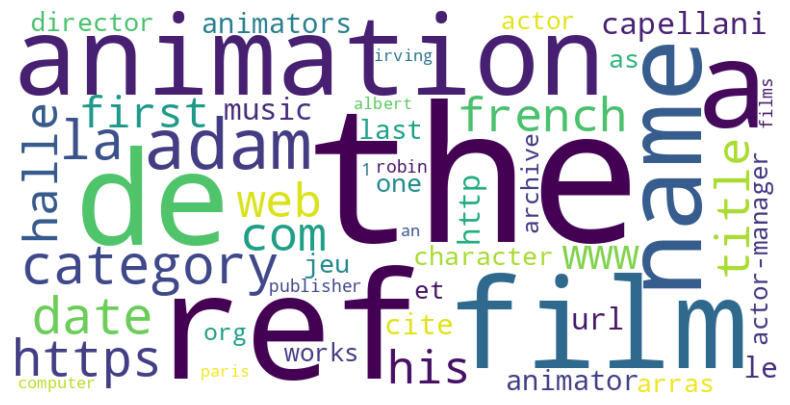

In [118]:
make_wordcloud(tokens1, 50)

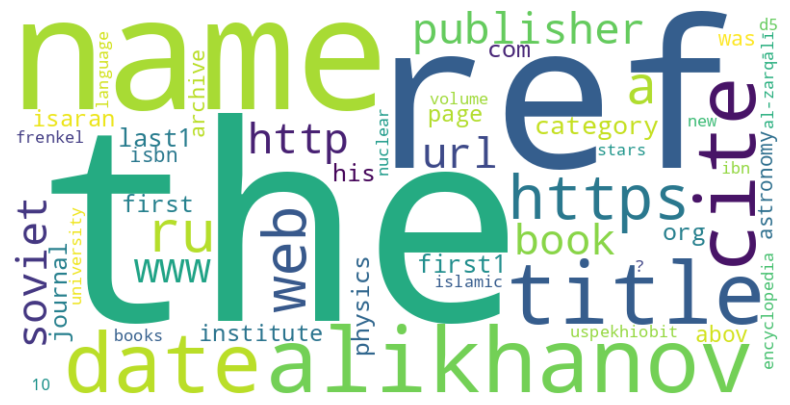

In [119]:
make_wordcloud(tokens2, 50)

In [120]:
# Create histogram and boxplot for sentence length per category with min/max/avg

In [121]:
def get_sentences(series):
    sentences = []
    for item in series:
        for para in item.split('\n'):
            for sent in nltk.sent_tokenize(para):
                sentences.append(sent)
    return sentences

In [122]:
sentences1 = get_sentences(df[df['category'] == category1]['text'])
sentences2 = get_sentences(df[df['category'] == category2]['text'])

In [123]:
def get_length_dict(sentences):
    lengths = {}
    for sentence in sentences:
        len_sentence = len(sentence.split(' '))
        if lengths.get(len_sentence):
            lengths[len_sentence] += 1
        else:
            lengths[len_sentence] = 1
    expanded = []
    for key, count in lengths.items():
        expanded.extend([key] * count)
    return lengths, expanded

In [124]:
length_sentence1, expanded1 = get_length_dict(sentences1)
length_sentence2, expanded2 = get_length_dict(sentences2)

In [130]:
print('Min category 1:', min(length_sentence1))
print('Max category 1:', max(length_sentence1))
print('Avg category 1:', sum(length_sentence1) / len(length_sentence1))
print('Min category 2:', min(length_sentence2))
print('Max category 2:', max(length_sentence2))
print('Avg category 2:', sum(length_sentence2) / len(length_sentence2))

Min category 1: 1
Max category 1: 94
Avg category 1: 29.727272727272727
Min category 2: 1
Max category 2: 90
Avg category 2: 33.095238095238095


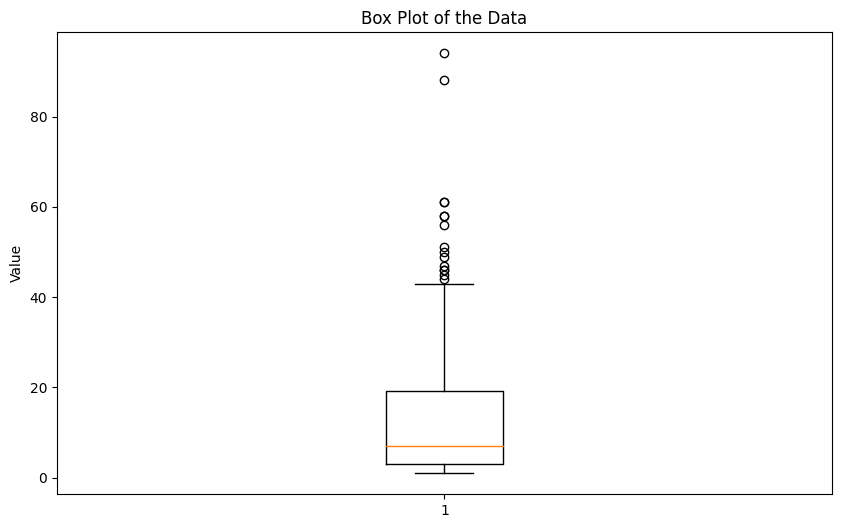

In [125]:
plt.figure(figsize=(10, 6))
plt.boxplot(expanded1)
plt.title("Box Plot of the Data")
plt.ylabel("Value")
plt.show()

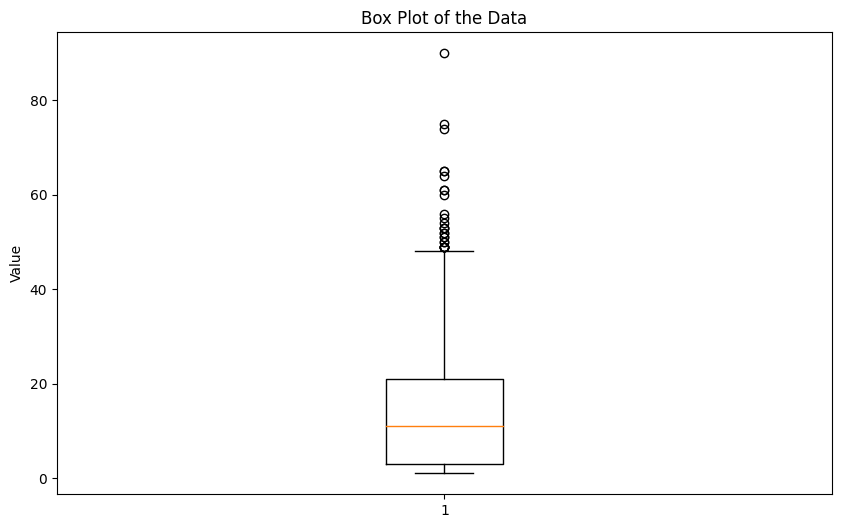

In [126]:
plt.figure(figsize=(10, 6))
plt.boxplot(expanded2)
plt.title("Box Plot of the Data")
plt.ylabel("Value")
plt.show()

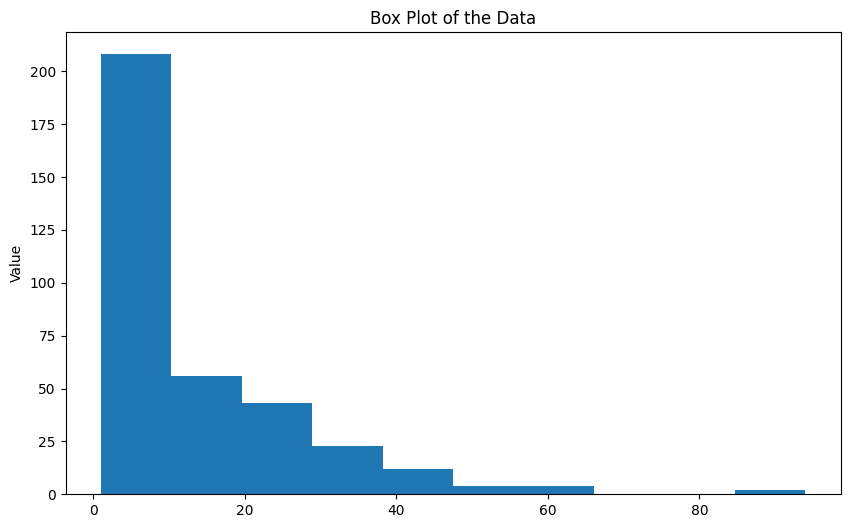

In [131]:
plt.figure(figsize=(10, 6))
plt.hist(expanded1)
plt.title("Box Plot of the Data")
plt.ylabel("Value")
plt.show()

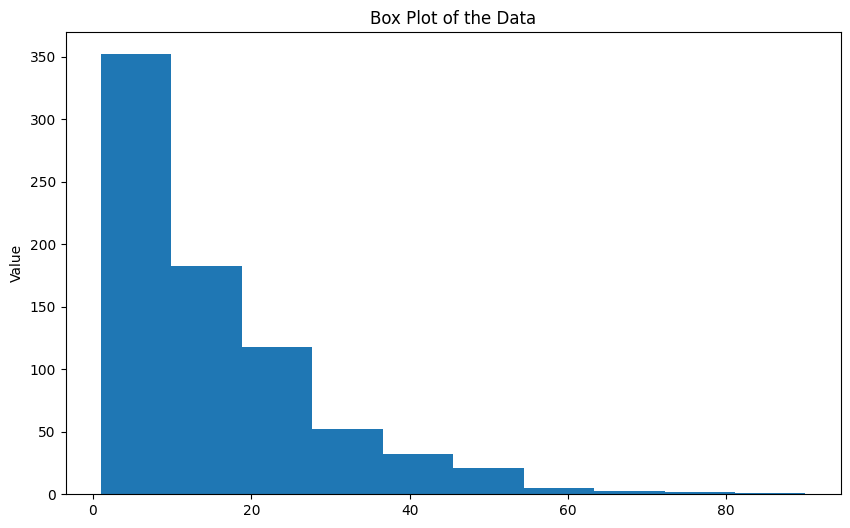

In [133]:
plt.figure(figsize=(10, 6))
plt.hist(expanded2)
plt.title("Box Plot of the Data")
plt.ylabel("Value")
plt.show()

In [ ]:
# ?? Total number of bi-gram occurences per category. min/max/avg

In [ ]:
# Query rdf properties for 50 most frequent properties (I think this means predicates) and create word cloud

In [ ]:
# Create histograms and boxplot for number of facts per category. min/max/avg

In [ ]:
# Train KMeans clustering (n_clusters=2). Cluster based on text (?) and, separately, on facts

In [ ]:
# Compute supervised and unsupervised metrics and visualizations to compare results

In [ ]:
# Function that process a document and return the set of named entities(NEs) (Spacy)

In [ ]:
# Same as above but with Stanza

In [ ]:
# Get statistics for each output (avg/min/max number of NEs)

In [ ]:
# Get statistics for each output (avg/min/max number of words (unclear use of word 'word'))

In [ ]:
# Visualize the above 2 statistics (per category, per package)

In [ ]:
# Write a function that takes a single document and performs the following 5 tasks

In [ ]:
    # Returns # of spans that both packages agree on

In [ ]:
    # Returns # of partial agreements on spans

In [ ]:
    # Returns for each package # of spans that one package predicted as a NE and the other did not

In [ ]:
    # Returns for all spans with full and partial agreement, agreement about NE types (aka Person, Location, Organisation, etc.)

In [ ]:
    # Visualize the above statistics

In [ ]:
# For each set of NEs predicted by each package, how many of them can be found in the knowledge graph (KG)

In [ ]:
# For each package, the ratio of predicted NEs that can be found in the KG of a person

In [ ]:
# Bonus points